In [1]:
import squidpy as sq
import scanpy as sc
import spatialdata as sd
import spatialdata_plot
from pathlib import Path
import seaborn as sns
import pandas as pd
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt

In [2]:
runLabel = 'Xenium_Prime_Cervical_Cancer_FFPE'
xenium_path = "/home/hanyue/code/biomecha/data/large_data/"+runLabel+".zarr"
save_path = '/home/hanyue/code/biomecha/data/large_data/Results/' + runLabel +'_test'
Path(save_path).mkdir(parents=True, exist_ok=True)
sdata = sd.read_zarr(xenium_path)
sdata

/home/hanyue/anaconda3/envs/py310bio/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


SpatialData object with:
├── Images
│     ├── 'he_image': MultiscaleSpatialImage[cyx] (3, 46545, 38219), (3, 23272, 19109), (3, 11636, 9554), (3, 5818, 4777), (3, 2909, 2388)
│     └── 'morphology_focus': MultiscaleSpatialImage[cyx] (5, 51205, 54125), (5, 25602, 27062), (5, 12801, 13531), (5, 6400, 6765), (5, 3200, 3382)
├── Labels
│     ├── 'cell_labels': MultiscaleSpatialImage[yx] (51205, 54125), (25602, 27062), (12801, 13531), (6400, 6765), (3200, 3382)
│     └── 'nucleus_labels': MultiscaleSpatialImage[yx] (51205, 54125), (25602, 27062), (12801, 13531), (6400, 6765), (3200, 3382)
├── Points
│     └── 'transcripts': DataFrame with shape: (113697508, 13) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (840387, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (840387, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (825663, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (840387, 5101)
with coordinate systems:
▸ 'global', wit

In [3]:
adata = sdata["table"].copy()
adata

AnnData object with n_obs × n_vars = 840387 × 5101
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

# Preprocessing

In [4]:
import sys
sys.path.append('/home/hanyue/code/biomecha/SpatialZoomer/SpatialZoomer_clean/')
from Preprocessing  import *

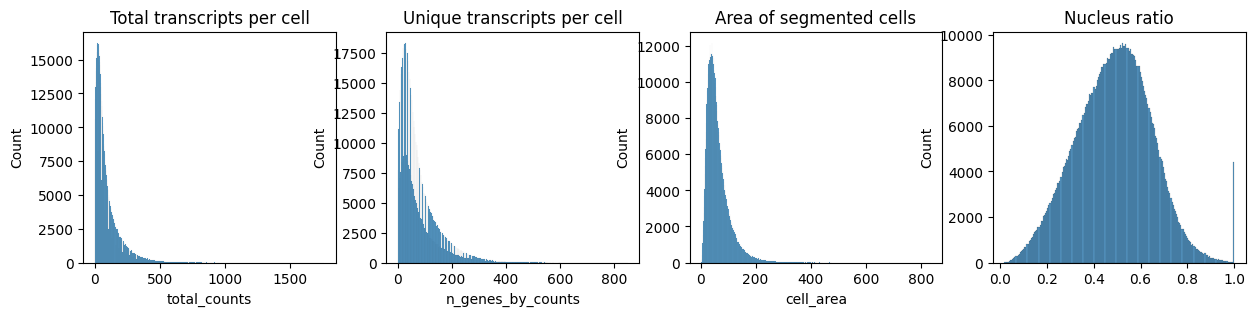

In [5]:
sc.pp.calculate_qc_metrics(adata, percent_top=(10, 20, 50, 150), inplace=True)
plot_qc_hist(adata)

In [6]:
sc.pp.filter_cells(adata, min_counts = 5)
sc.pp.filter_cells(adata, min_genes = 5)
sc.pp.filter_genes(adata, min_cells = 5)
adata = adata[~adata.obs['nucleus_area'].isna(), :]
adata = Preprocess(adata)
adata

/home/hanyue/code/biomecha/SpatialZoomer/SpatialZoomer_clean/Preprocessing.py:39: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


AnnData object with n_obs × n_vars = 801131 × 5098
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatialdata_attrs', 'log1p'
    obsm: 'spatial'
    layers: 'counts'

# GWT

In [7]:
from Spectral_graph_filter_bank import *
import importlib
importlib.reload(sys.modules['Spectral_graph_filter_bank'])

<module 'Spectral_graph_filter_bank' from '/home/hanyue/code/biomecha/SpatialZoomer/SpatialZoomer_clean/Spectral_graph_filter_bank.py'>

In [8]:
n_neighbors = 20
adata = performDR(adata, type = 'NMF', n_components=50)
adata = getKNN(adata, use_rep = 'spatial', name = 'spatial_knn', n_neighbors = n_neighbors)
adata = getKNN(adata, use_rep = 'X_nmf', name = 'expr_knn', n_neighbors = n_neighbors)

import time
start_time_all = time.time()

scales = [0.01] + np.arange(0.1, 2.1, 0.1).tolist() + np.arange(2.5, 15.5, 0.5).tolist() + np.arange(16, 21, 1).tolist() +  np.arange(25, 55, 5).tolist()
scales = [round(x, 2) for x in scales]
transformed_signals, scales = performSGFB(adata, use_knn = 'spatial_knn', use_rep = 'X_nmf', scales = scales, runLabel = runLabel, save_path = save_path)
print(transformed_signals.shape)

Time taken to perform NMF: 460.5721 seconds
Maximum similarities:  71.62885418966758
Minimum similarities:  0.35329165220287845
Median similarities:  5.413613841315116
time taken to construct spatial_knn: 4.7213 seconds
Maximum similarities:  7408378.173215321
Minimum similarities:  552.1669068366899
Median similarities:  2048.863953863085
time taken to construct expr_knn: 305.6054 seconds
Time taken to perform spectral graph filter bank: 681.9405 seconds
Transformed signals saved to /home/hanyue/code/biomecha/data/large_data/Results/Xenium_Prime_Cervical_Cancer_FFPE_test/Xenium_Prime_Cervical_Cancer_FFPE_transformed_signals.h5
(801131, 50, 58)


In [23]:
460.5721   / 60

7.676201666666667

# Identify typical frequency

In [9]:
from Identify_typical_scales import *
from matplotlib import rcParams
import matplotlib as mpl  


config = {
    "font.family":'sans-serif',
    "font.size": 6,
    "mathtext.fontset":'stix',
    "font.serif": ['MS Arial'],
}
rcParams.update(config)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

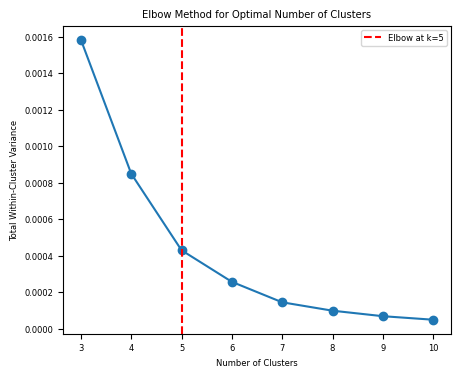

The optimal number of clusters is: 5


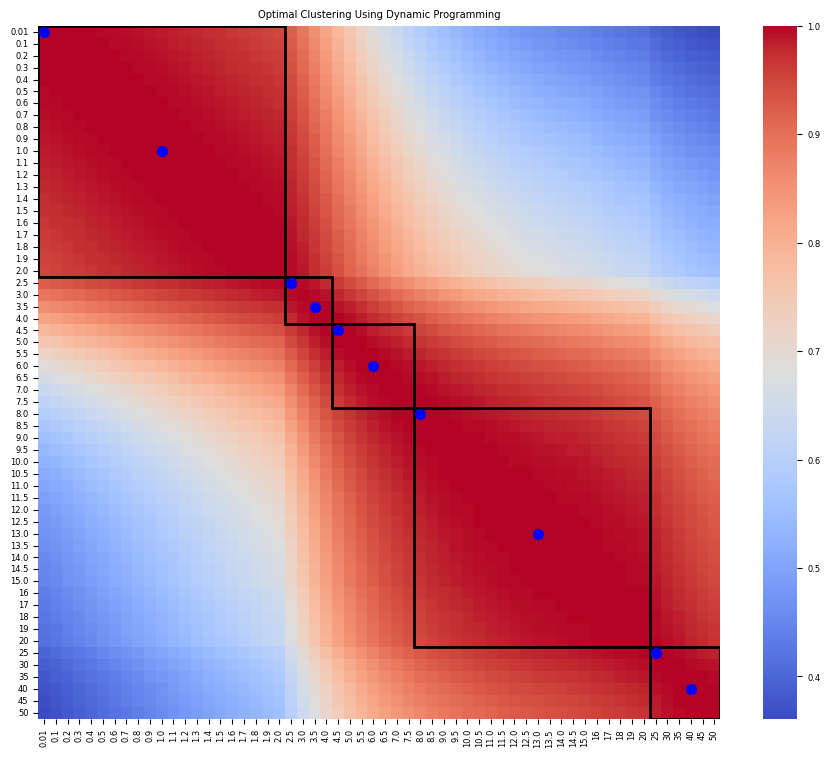

Optimal clusters (start, end): [(0, 20), (21, 24), (25, 31), (32, 51), (52, 57)]
Cluster centers: [1.0, 3.5, 6.0, 13.0, 40]
Typical scales: [0.01, 1.0, 2.5, 3.5, 4.5, 6.0, 8.0, 13.0, 25, 40]
Time taken to perform identification of typical scales: 72.7903 seconds


,Index,Scale
0,0,0.01
1,10,1.00
2,21,2.50
3,23,3.50
4,25,4.50
5,28,6.00
6,32,8.00
7,42,13.00
8,52,25.00
9,55,40.00


In [10]:
mean_correlation_matrix, optimal_clusters, typical_scales_df = Identify_Typical_Scales(transformed_signals, scales, max_clusters = 10, min_clusters = 3, 
                                                                             save_path = save_path+'/'+ runLabel )
typical_scales_df 

# Clustering

In [11]:
from Two_step_Clustering import *
import importlib
importlib.reload(sys.modules['Two_step_Clustering'])


<module 'Two_step_Clustering' from '/home/hanyue/code/biomecha/SpatialZoomer/SpatialZoomer_clean/Two_step_Clustering.py'>

In [12]:
resolutions = [0.4, 0.6, 0.8, 1, 1.2]
adata = Clustering_raw_signal(adata, use_rep = 'X_nmf',  n_clusters_kmeans = 10000, resolutions = resolutions, title = 'Raw', save_path = save_path, runLabel = runLabel)

Time taken to perform UMAP and clustering for raw signal: 436.4598 seconds


In [13]:
adata = Clustering_transformed_signal(adata, transformed_signals, typical_scales_df, n_clusters_kmeans = 10000, resolutions = resolutions, save_path = save_path, runLabel = runLabel)

Time taken to perform clustering for signal at scale 0.01: 542.1920 seconds
Time taken to perform clustering for signal at scale 1.0: 551.7927 seconds
Time taken to perform clustering for signal at scale 2.5: 539.7347 seconds
Time taken to perform clustering for signal at scale 3.5: 533.3993 seconds
Time taken to perform clustering for signal at scale 4.5: 551.7690 seconds
Time taken to perform clustering for signal at scale 6.0: 550.5169 seconds
Time taken to perform clustering for signal at scale 8.0: 534.0391 seconds
Time taken to perform clustering for signal at scale 13.0: 571.7944 seconds
Time taken to perform clustering for signal at scale 25.0: 532.4379 seconds
Time taken to perform clustering for signal at scale 40.0: 544.1184 seconds
Total time: 5453.7040 seconds


In [21]:
(5453.7040 + 436.4598 )/60

98.16939666666666

# Identify simpson index

In [14]:
from Simpson_Index import *
importlib.reload(sys.modules['Simpson_Index'])


<module 'Simpson_Index' from '/home/hanyue/code/biomecha/SpatialZoomer/SpatialZoomer_clean/Simpson_Index.py'>

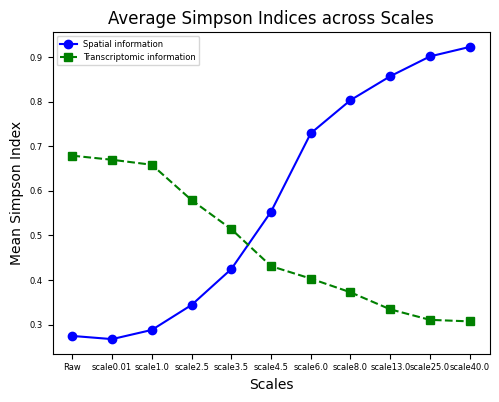

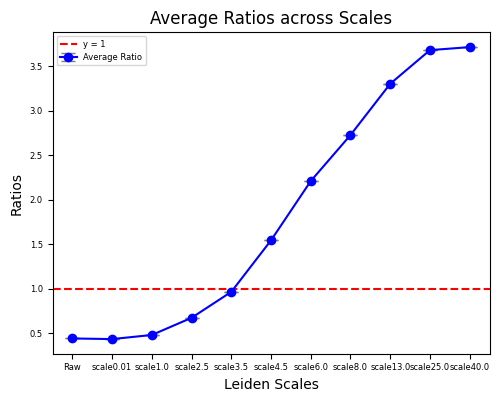

In [15]:
typical_scales = typical_scales_df['Scale'].values
scales_plot = ['Raw'] + ['scale' + str(scale) for scale in typical_scales]
clusters_use = ['leiden_' + str(scale) + '_res1' for scale in scales_plot]
simpson_spatial_dict, simpson_expr_dict, ratios_dict = plot_simpson_indices(adata, scales_plot, clusters_use, save_path = save_path+'/')


In [16]:
adata.write(save_path + '/' + runLabel +'_GWT_anndata.h5ad')

In [17]:
end_time_all = time.time()
elapsed_time = end_time_all - start_time_all
print(f"Time taken to perform SpatialZoomer: {elapsed_time:.4f} seconds")


Time taken to perform SpatialZoomer: 6717.1174 seconds


In [19]:
6717.1174 / 60 /60

1.8658659444444445